In [6]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import  layers
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from tqdm import trange

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_bloch_multivector
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp

from qiskit_aer.primitives import EstimatorV2

In [8]:
def get_data():
    data, ds_info = tfds.load(
        'cifar10',
        split='train',
        shuffle_files=True,
        as_supervised=True,
        with_info=True,
    )
    df = tfds.as_dataframe(data.take(1000),ds_info)
    
    print("Separando dados...")
    cats_dogs = df.loc[(df.label == 3) | (df.label == 5)].reset_index()
    cats_dogs = cats_dogs.drop(axis=0, columns='index')

    print("Adqurindo labels...")
    labels = cats_dogs.label.to_numpy().astype(np.uint8)
    labels[labels == 3] = 0
    labels[labels == 5] = 1

    print("Normalizando imagens...")
    original_images = np.stack(cats_dogs.image.to_numpy()/255.0)
    new_images = np.zeros(shape=(original_images.shape[0],10,10,1), dtype=np.float32)

    for image_i in trange(new_images.shape[0]):
        new_image = original_images[image_i]
        new_image = tf.image.convert_image_dtype(new_image, dtype=tf.float32)
        new_image = tf.image.resize(new_image, (10,10))
        new_image = tf.image.rgb_to_grayscale(new_image)
        new_images[image_i] = new_image

    print("Separando em Train/Test...")
    return train_test_split(new_images, labels, test_size=0.10, random_state=37)


In [9]:
X_train, X_test, y_train, y_test = get_data()

2024-11-03 12:59:06.437205: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Separando dados...
Adqurindo labels...
Normalizando imagens...


100%|██████████| 204/204 [00:00<00:00, 669.38it/s]

Separando em Train/Test...


In [12]:
"""
    Exercício 1:

    Sua tarefa nessa parte do código é criar uma Quantum Convolutional Layer diferente das que foram apresntadas.

    Para isso, teste diversos formatos. Você pode invetar a sua usando os gates presentes no `Qiskit` ou ainda 
    métodos outros métodos já conhecidos. Aqui vão algumas ideias e links interessantes para esse desafio:

    - Utilizar `ry` e/ou `rz` ao invés de `rx`
    - Utiliza `cx` e/ou `cz` ao invés do conjunto `crx` + `crz`
    - Teste diferentes filtros para a camada, crie os seus próprios filtros ou utilize ansatzes conhecidas como TwoLocal ou EfficientSU2
        - https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.TwoLocal
        - https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.EfficientSU2
    - Criar outros padrões de interligação entre os qbuits
    - Testar diferentes formatos de encoding como ZFeatureMap e ZZFeatureMap
        - https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.ZFeatureMap
        - https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.ZZFeatureMap
    
    Obs: Dependendo das suas moficações será necessário adicionar mais parâmetros (pesos) na rede
"""


class QuantumConv2DPool(layers.Layer):
    def __init__(self):
        super(QuantumConv2DPool, self).__init__()
        self._n_params = 21 # aumente ou diminua o número de parâmetros baseado nas suas modificações
        self.w = self.add_weight(
            shape=(1,self._n_params),
            initializer=tf.constant_initializer(np.random.uniform(low=0, high=np.pi, size=(1,self._n_params))),
            trainable=True,
        )
        self._params = ParameterVector("theta",self._n_params)
        self._circuit = None
        self._obs = SparsePauliOp("IIIZ")
        self._estimator = EstimatorV2()
    
    def _build_circuit(self, data):
        self._circuit = QuantumCircuit(4)

        ### MODIFQUE AQUI!!!!!

        self._encode_data(data)

        self._circuit.barrier()
        #Conv
        self._circuit.rx(self._params[0], 0)
        self._circuit.rx(self._params[1], 1)
        self._circuit.rx(self._params[2], 2)
        self._circuit.rx(self._params[3], 3)

        self._circuit.crx(self._params[4], 1, 0)
        self._circuit.crz(self._params[5], 1, 0)

        self._circuit.crx(self._params[6], 2, 1)
        self._circuit.crz(self._params[7], 2, 1)

        self._circuit.crx(self._params[8], 3, 2)
        self._circuit.crz(self._params[9], 3, 2)

        self._circuit.barrier()
        # Pool
        self._circuit.crz(self._params[10], 1,0)
        self._circuit.crx(self._params[11], 1,0)

        self._circuit.crz(self._params[12], 3,2)
        self._circuit.crx(self._params[13], 3,2)

        self._circuit.barrier()
        # Conv
        self._circuit.rx(self._params[14], 0)
        self._circuit.rx(self._params[15], 2)
        
        self._circuit.crz(self._params[16], 2, 0)
        self._circuit.rz(self._params[17], 0)
        self._circuit.crz(self._params[18], 0, 2)

        self._circuit.barrier()
        # Pool
        self._circuit.crz(self._params[19], 2,0)
        self._circuit.crx(self._params[20], 2,0)

        ################

    @staticmethod
    def _get_angle(x):
        return 2*np.arcsin(x)

    def _encode_data(self, data):
        ### MODIFQUE AQUI!!!!!

        for i,pixel in enumerate(data):
            self._circuit.ry(self._get_angle(pixel), i)
            
        ################
        

    def _measure(self):
        weights = self.w.value.numpy()[0]
        results = self._estimator.run([(self._circuit, self._obs, weights)]).result()
        return results[0].data.evs

    def call(self,inputs):
        h,w,_ = inputs.shape
        output = np.zeros(shape=(int(np.ceil(h/2)),int(np.ceil(w/2)),1))
        for i in range(0,h,2):
            for j in range(0,w,2):
                data = [
                    inputs[i][j][0],
                    0 if i+1 > h-1 else inputs[i+1][j][0],
                    0 if j+1 > w-1 else inputs[i][j+1][0],
                    0 if i+1 > h-1 or j+1 > w-1 else inputs[i+1][j+1][0]
                ]

                self._build_circuit(data)
                result = self._measure()
                
                output[i//2][j//2][0] = result

        return output

    def show_circuit(self):
        self._build_circuit([0,0,0,0])
        display(self._circuit.draw('mpl'))


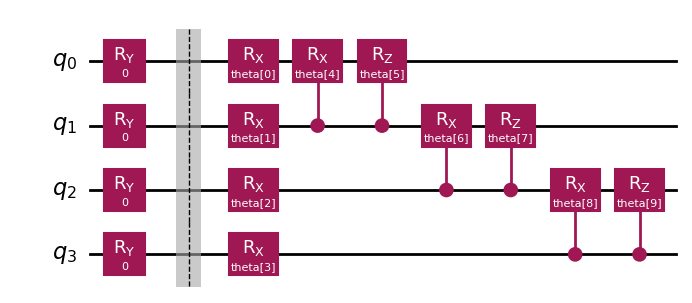

In [13]:
conv_layer = QuantumConv2D()
conv_layer.show_circuit()

In [ ]:
"""
    Exercício 2:

    Agora, sua tarefa é modificar a arquitetura da rede para tentar reduzir o overfitting(https://developers.google.com/machine-learning/crash-course/overfitting/overfitting)

    Para isso, modifique a arquitetura adicionando mais Dense Layers, DropOut e/ou ainda utilizando Data augmentation.
        - https://www.tensorflow.org/tutorials/images/data_augmentation
        - https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout

    obs: A QuantumConv2DPool Layer deve ser sempre a primeira (apenas data augmentation é possível antes da quantum layer) e as imagens devem ser sempre no tamanho 10x10
"""

class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()

        ### MODIFIQUE AQUI!!!


        ################

        self.conv = QuantumConv2DPool()
        self.fc = layers.Dense(5*5, activation="relu", input_shape=(25,))

        ### MODIFIQUE AQUI!!!


        ################

        self.out = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        ### MODIFIQUE AQUI!!!


        ################

        x = self.conv(inputs[0]) #in: 10x10 out: 5x5 
        x = np.expand_dims(x.flatten(), axis=0)

        ### MODIFIQUE AQUI!!!

        x = self.fc(x)
        return self.out(x)

        ################

In [ ]:
model = Model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4), # aqui vocêtambém pode aumentar esse valor do otimizador para tentar um melho resultado
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
    run_eagerly=True
)

In [ ]:
model.fit(x=X_train, y=y_train, epochs=20, batch_size=1) # você também pode reduzir o tamanho do batch para ser mais rápido. No entanto deixe o batch_size=1 sempre

In [14]:
def test():
    corrects = 0 
    wrongs = 0

    for i,x in enumerate(X_test):
        pred = np.round(model.predict(np.expand_dims(x,axis=0))[0][0])
        correct = y_test[i] == pred

        if(correct):
            print("Correct!")
            corrects += 1
        else:
            print("Wrong!")
            wrongs += 1
    print(f"Corrects: {corrects}, Wrongs: {wrongs}")

In [ ]:
test()

# DESAFIO

Com seus novos conhecimentos, desafio você a criar um modelo para diferenciar carros e caminhões (labels 1 e 9).  (https://www.cs.toronto.edu/~kriz/cifar.html)

Seja criativo e me mostre seus resultados ;)